### 2. Необходимо скачать и подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks для обучения

<div class="alert alert-block alert-success">
<p>
При запуске обучения были допущены ошибки: <br>
Не обнулялся running_loss при выводе на печать, поэтому он "накапливался" при отображении <br>
Не отмасштабированы значения outputs  и labels, поэтому loss выдает корявое значение. <br>

Понял свои ошибки уже задним числом, срок сдачи домашки подходит к концу. Перезапускать обучение достаточно долгое занятие.

</p>
</div>

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [2]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch.nn import functional as F

In [3]:
import time
import segmentation_models_pytorch as smp

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth =1
        num = targets.size(0)
        probs = F.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score =2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score =1 - score.sum() / num
        return score

In [6]:
path = 'D:/LipsSegmentation/set-lipstick-original/'

In [7]:
np.unique(plt.imread('D:/LipsSegmentation/set-lipstick-original/mask/mask00000001.png')[:,:,0]*255)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  71.,  72.,  74.,  75.,  76.,  78.,  86.,  93.,
       101.], dtype=float32)

In [8]:
image = plt.imread(path + '720p/image00000001.jpg')
mask = plt.imread(path + 'mask/mask00000001.png')

In [9]:
mask[mask >= 0.08] = 1
mask[mask < 0.08] = 0

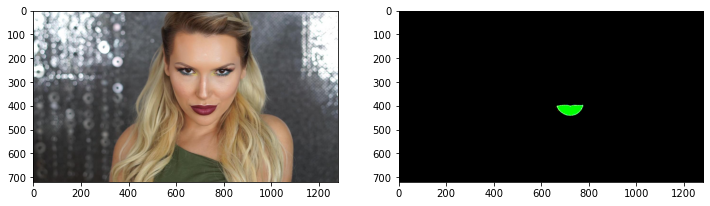

In [10]:
f, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(image) 
ax[1].imshow(mask)
plt.show()

In [11]:
lab = np.asarray(plt.imread(path + 'mask/mask00000001.png'))[:,:,0]*255
# lab[lab > 0.06] = 1
# lab[lab < 0.06] = 0
# # lab = np.asarray(lab)*255

# #lab = np.asarray(plt.imread(path + 'mask/mask00000001.png'))[:,:,0]*255
# # Упаковываем ее в pytorch-тензор и оборачиваем ее в батч из одной каринки,
# # но при этом заполняем 13 каналов масками нужных классов
# # Т.е. там, где например класс автомобилей (10 по счету канал) - все пиксели 0 
# # если не принадлежат классу, и 1 если принадлежат 
x_out = torch.as_tensor(np.where(lab == 0, 255, 0)).unsqueeze(0)
for i in range(1, 50):
    mask1 = np.asarray(plt.imread(path + 'mask/mask00000001.png'))[:,:,0]*255
    mask1 = np.where(mask1 == i, 255, 0)
    x = torch.as_tensor(mask1).unsqueeze(0)
    x_out =  torch.cat((x_out,x),dim=0)       
x_out = x_out.float()

lab = x_out.unsqueeze(0)
# # делаем ресайз картинки на 256х256
lab = F.interpolate(input=lab, size=256, mode='nearest')

In [12]:
lab = np.asarray(Image.open(path + 'mask/mask00000001.png')).astype('float')
lab = torch.as_tensor(lab)  
lab[lab < 35] = 0
lab[lab != 0] = 1
lab = lab.unsqueeze(0).permute(0,3,1,2)
lab =  F.interpolate(input=lab, size=256, mode='nearest')
lab = lab[0,0,:,:]

x_out = torch.as_tensor(np.where(lab == 0, 255, 0)).unsqueeze(0)
for i in range(1, 2):
    mask = lab
    mask = np.where(mask == i, 255, 0)
    x = torch.as_tensor(mask).unsqueeze(0)
    x_out =  torch.cat((x_out,x),dim=0)       
x_out = x_out.float()
lab = x_out.unsqueeze(0)

lab.size()

torch.Size([1, 2, 256, 256])

In [17]:
np.unique(plt.imread('D:/LipsSegmentation/set-lipstick-original/mask/mask00000001.png')[:,:,0])*255

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  71.,  72.,  74.,  75.,  76.,  78.,  86.,  93.,
       101.], dtype=float32)

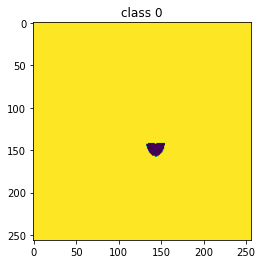

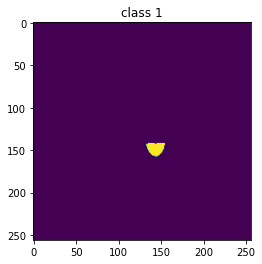

In [18]:
lab = np.asarray(Image.open('D:/LipsSegmentation/set-lipstick-original/mask/mask00000001.png').convert('LA')).astype('float')
lab = torch.as_tensor(lab)
lab[lab < 35] = 0
lab[lab != 0] = 1
lab = lab.unsqueeze(0).permute(0,3,1,2)
lab =  F.interpolate(input=lab, size=256, mode='nearest')

lois = lab[0,0,:,:]
# lois[lois < 35] = 0
# lois[lois != 0] = 1


for i in range(2):
    mask = lois
    mask = np.where(mask == i, 255, 0)
 #   mask = mask[:,:,0]
    plt.title(f'class {i}')
    plt.imshow(mask)
    plt.show()

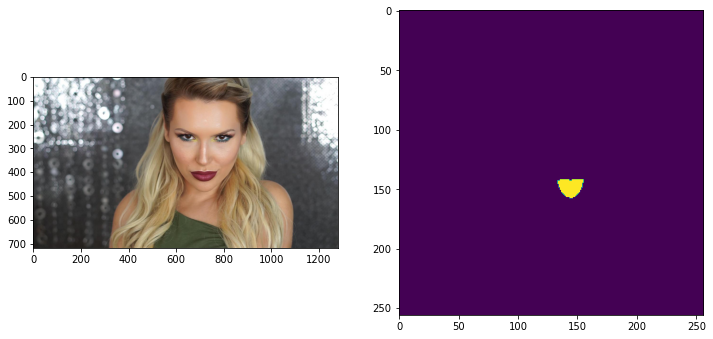

In [19]:
f, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(image) 
ax[1].imshow(mask)
plt.show()

In [20]:
df = pd.read_csv(path+'list.csv', delimiter=',', usecols=['filename', 'mask'])

In [21]:
df['filename'] = path + '720p/' + df['filename']
df['mask'] = path + 'mask/' + df['mask']

In [22]:
df.head(3)

,filename,mask
0,D:/LipsSegmentation/set-lipstick-original/720p...,D:/LipsSegmentation/set-lipstick-original/mask...
1,D:/LipsSegmentation/set-lipstick-original/720p...,D:/LipsSegmentation/set-lipstick-original/mask...
2,D:/LipsSegmentation/set-lipstick-original/720p...,D:/LipsSegmentation/set-lipstick-original/mask...


In [23]:
empty_list = []
for i in range(df.shape[0]):
    if os.path.exists(df['mask'].loc[i]) is False:
        empty_list.append(i)
 

In [24]:
df.drop(df.index[empty_list], inplace=True)

In [25]:
df.reset_index(drop=True, inplace=True)

In [26]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # 1) unsqueeze - меняет размерность img c (600, 800, 3) -> (1, 600, 800, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, 600, 800, 3) -> (1, 3, 600, 800)
        img = img.unsqueeze(0).permute(0,3,1,2)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с 800х600 на 256х256
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        
        # итаем сегментированную картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        #lab = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
#         lab = plt.imread(self.label_arr[index])[:,:,0]
#         lab[lab > 0.8] = 1
#         lab[lab < 0.8] = 0
#         lab = np.asarray(lab)*255
        
#         # Упаковываем ее в pytorch-тензор и оборачиваем ее в батч из одной каринки,
#         # но при этом заполняем 13 каналов масками нужных классов
#         # Т.е. там, где например класс автомобилей (10 по счету канал) - все пиксели 0 
#         # если не принадлежат классу, и 1 если принадлежат 
#         x_out = torch.as_tensor(np.where(lab == 0, 255, 0)).unsqueeze(0)
#         for i in range(1, 2):
#             mask = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
#             mask = np.where(mask == i, 255, 0)
#             x = torch.as_tensor(mask).unsqueeze(0)
#             x_out =  torch.cat((x_out,x),dim=0)       
#         x_out = x_out.float()
        
#         lab = x_out.unsqueeze(0)
#         # делаем ресайз картинки на 256х256
#         lab = F.interpolate(input=lab, size=256, mode='nearest')
        
        lab = np.asarray(Image.open(self.label_arr[index]).convert('LA')).astype('float')
        lab = torch.as_tensor(lab)  
        lab[lab < 35] = 0
        lab[lab != 0] = 1
        lab = lab.unsqueeze(0).permute(0,3,1,2)
        lab =  F.interpolate(input=lab, size=256, mode='nearest')
        lab = lab[0,0,:,:]
        
        x_out = torch.as_tensor(np.where(lab == 0, 255, 0)).unsqueeze(0)
        for i in range(1, 2):
            mask = lab
            mask = np.where(mask == i, 255, 0)
            x = torch.as_tensor(mask).unsqueeze(0)
            x_out =  torch.cat((x_out,x),dim=0)       
        x_out = x_out.float()
        lab = x_out.unsqueeze(0)
           
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

In [48]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df,test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [49]:
train_data_loader = DataLoader(train_data,batch_size=1,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=1,shuffle=False)

In [29]:
segmodel = smp.Unet('resnet34', classes=2, activation='softmax').to(device)

In [30]:
#segmodel = smp.Unet('mobilenet_v2', classes=2, activation='softmax').to(device)

In [31]:
epochs = 5
learning_rate = 0.001

In [32]:
optimizer = torch.optim.Adam(segmodel.parameters(), lr=learning_rate)
criterion = SoftDiceLoss()

In [33]:
total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")

5 epochs, 19978 total_steps per epoch


In [ ]:
epoch_losses = []

# Полезная функция для детектирования аномалий в процессе обучения
torch.autograd.set_detect_anomaly(True)

epoch_losses = []

for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = []
    t = 0
    time1 = time.time()
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = segmodel(inputs[0])
        loss = criterion(outputs,labels[0,0,:,:,:])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        t+=1
        if t % 1000 == 999:    # print every 5000 mini-batches
            print(f'Epoch: {epoch}, batchcount: {t}, avg. loss for last 1000 images: {running_loss/1000}')
            running_loss = 0
    time2 = time.time()
    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss),f' time = {time2-time1} sec')
    epoch_losses.append(epoch_loss)
    
    savePATH = './segmodel.pth'
    torch.save(segmodel.state_dict(), savePATH)

C:\Users\Pavel\Anaconda3\envs\pytorch\lib\site-packages\segmentation_models_pytorch\base\modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


Epoch: 0, batchcount: 999, avg. loss for last 1000 images: -0.16118586105108262
Epoch: 0, batchcount: 1999, avg. loss for last 1000 images: -0.33460302340984344
Epoch: 0, batchcount: 2999, avg. loss for last 1000 images: -0.500482979297638
Epoch: 0, batchcount: 3999, avg. loss for last 1000 images: -0.6555287772417069
Epoch: 0, batchcount: 4999, avg. loss for last 1000 images: -0.8200854996442795
Epoch: 0, batchcount: 5999, avg. loss for last 1000 images: -0.9821326268315316
Epoch: 0, batchcount: 6999, avg. loss for last 1000 images: -1.1440968334674835
Epoch: 0, batchcount: 7999, avg. loss for last 1000 images: -1.310250683069229
Epoch: 0, batchcount: 8999, avg. loss for last 1000 images: -1.4741710425019263
Epoch: 0, batchcount: 9999, avg. loss for last 1000 images: -1.636217342197895
Epoch: 0, batchcount: 10999, avg. loss for last 1000 images: -1.8036969575881958
Epoch: 0, batchcount: 11999, avg. loss for last 1000 images: -1.9682361388802527
Epoch: 0, batchcount: 12999, avg. loss f

In [34]:
savePATH = './segmodel.pth'
#torch.save(segmodel.state_dict(), savePATH)

In [35]:
segmodel=smp.Unet('resnet34', classes=2, activation='softmax').to(device)
segmodel.load_state_dict(torch.load(savePATH))

<All keys matched successfully>

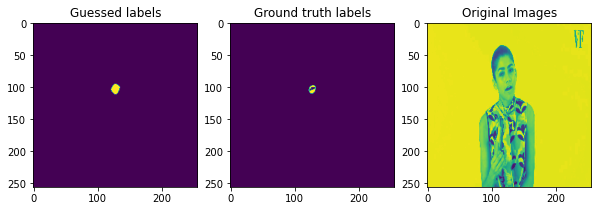

<ipython-input-50-a91b3d66b078>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.gcf().show()


<Figure size 432x288 with 0 Axes>

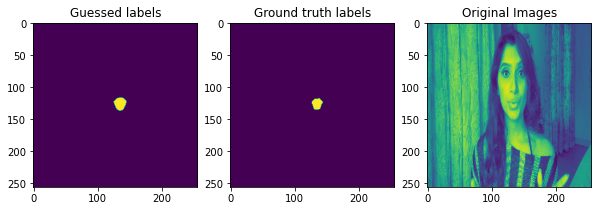

<Figure size 432x288 with 0 Axes>

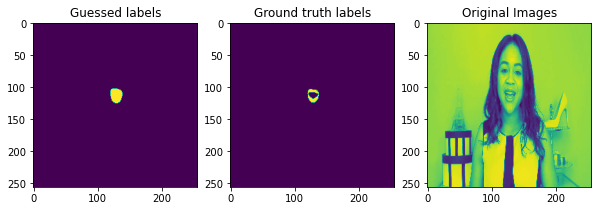

<Figure size 432x288 with 0 Axes>

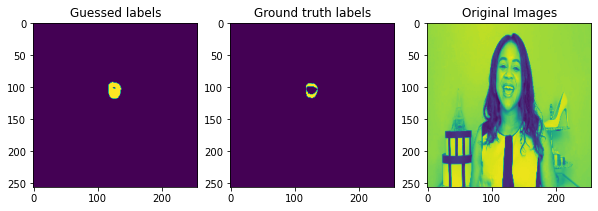

<Figure size 432x288 with 0 Axes>

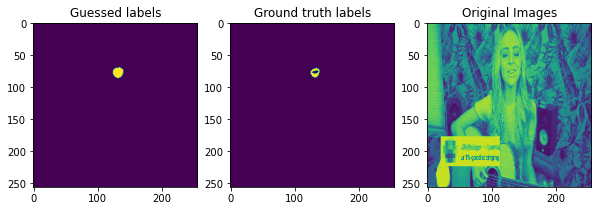

<Figure size 432x288 with 0 Axes>

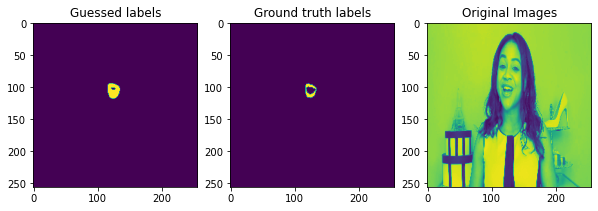

<Figure size 432x288 with 0 Axes>

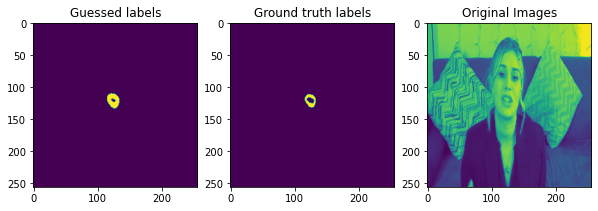

<Figure size 432x288 with 0 Axes>

In [50]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    images = images.cuda()
#     labels = labels.cuda()
    outputs = segmodel(images[0])
    f, axarr = plt.subplots(1,3, figsize=(10, 10))
    
   # original = get_orig(images[0][0,:,:,:])
    
    axarr[0].imshow(torch.argmax(outputs[0].squeeze(), dim=0).detach().cpu().numpy())
    axarr[0].set_title('Guessed labels')
    
    axarr[1].imshow(torch.argmax(labels[0].squeeze(), dim=0).detach().cpu().numpy())
    axarr[1].set_title('Ground truth labels')
    
       
    axarr[2].imshow(images[0].detach().cpu().numpy()[0,0,:,:])
    axarr[2].set_title('Original Images')
    plt.show()
    plt.gcf().show()
    if i>5:
        break

In [53]:
criterion(outputs.cpu(), labels[0,0,:,:,:].cpu()//255)

tensor(0.5738, grad_fn=<RsubBackward1>)